In [1]:
# Basic dependencies
import qiskit.pulse as pulse

from utility import *
from constant import *
from unitary_gate import *
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import IBMQ, schedule, QuantumCircuit

import numpy as np
import random

if not IBMQ.active_account():
    IBMQ.load_account()
    
# We'll be using ibm_oslo, qubit 0 as the most suitable options that is currently available
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

%config InlineBackend.figure_formats = ['svg']

# Theory 

This experiment is designed to observe Rabi oscillations on the Hilbert subspace spanned by $|1\rangle$ and $|2\rangle$, as it is effectively treated as a two-level quantum system interacting with a driving field 

\begin{align}
\epsilon(t) = \Omega(t)\cos(\omega_D t - \phi),
\end{align}

where $\omega_D$ matches with the transition frequency of the two levels, i.e. $\omega_D = E_2-E_1$ ($\hbar=1$). Initially, the qutrit will be excited to the first level using a $\pi_x^{(01)}$ pulse. By varying the driving amplitude (i.e. the real part $\Omega_x(t)$ of $\Omega(t)$) and evolving the total $\hat{H}$ a duration $T$, we can observe $P(|2\rangle)$ as a function of $\theta$ ($\Omega_x(t)=f(\theta)$). 

In the superconducting circuit model, this can be viewed as

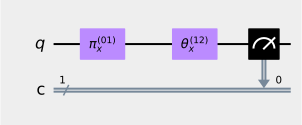

In [7]:
pi_x_01 = Gate(r'$\pi_x^{(01)}$', 1, [])
theta_x_12 = Gate(r'$\theta_x^{(12)}$', 1, [])

amp12 = QuantumCircuit(1, 1)
amp12.append(pi_x_01, [0])
amp12.append(theta_x_12, [0])
amp12.measure(0, 0)
amp12.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

Adopting the model of Fishcher (PRR 2022), we shall refer to this circuit as two consecutive unitaries acting on the initially prepared ground state,

\begin{align}
|\psi(\theta)\rangle = \theta_x^{(12)}\pi_x^{(01)}|0\rangle
\end{align}

So far we've devised an effective calibration routine for the first pulse. The calibration consists of 3 steps,

1. Raw Rabi oscillation on (0-1)
2. Fine-tuning amplitude for $\pi/2_x^{(01)}$ and $\pi_x^{(01)}$ (Sheldon 2015)
3. DRAG's $\beta$ fine-tuning for both leakage error and dephasing error (Chow 2010)

We can safely say that this gate is well realized. Also, according to (Fischer, 2022) this gate imposes a non-trivial phase on $|2\rangle$. Though not measured, we can ignore this phase as it would not be mapped into a observable.

Text(0, 0.5, '$P(|2\\rangle)$')

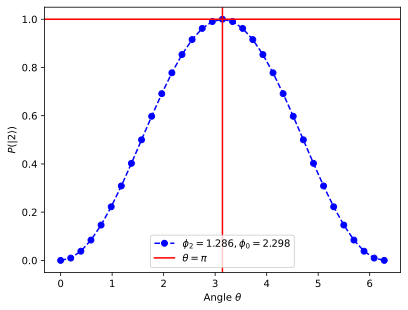

In [8]:
thetas = np.linspace(0, 2*pi, 33)
phi2 = random.uniform(0, pi)
phi0 = random.uniform(0, pi)
pop2 = []
for theta in thetas:
    psi_theta = r12(theta, 1, 2, phi0)@r01(pi, 0, 0, phi2)@psi('g')
    pop2.append(abs(psi_theta[2])**2)

plt.figure()
plt.plot(thetas, pop2, '--bo', label=r'$\phi_2=$'+f'{round(phi2, 3)}'+r'$, \phi_0=$'+f'{round(phi0, 3)}')
plt.axvline(pi, linestyle="-", color="r", label=r'$\theta=\pi$')
plt.axhline(1, linestyle="-", color="r")
plt.legend()
plt.xlabel(r"Angle $\theta$")
plt.ylabel(r"$P(|2\rangle)$")

# Cryostat

*“Quantum phenomena do not occur in a Hilbert space. They occur in a laboratory.”* ―Asher Peres

In [9]:
# Last revised 4th December 2022
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{QUBIT}']/(2*np.pi)
anhar = (backend.properties().qubits[QUBIT][3].value)*1e9


def g01(dur, amp, theta, beta, phi):
    with pulse.build(backend=backend) as g01:
        pulse.set_frequency(drive_freq, pulse.drive_channel(QUBIT))
        with pulse.phase_offset(phi, pulse.drive_channel(QUBIT)):
            pulse.play(pulse.Drag(dur, (theta*amp)/pi, dur/4, beta, 
                                  r'$\mathcal{G}^{01}$'+f'({round(theta, 2)}, {round(phi, 2)})'),
                       pulse.drive_channel(QUBIT))
    return g01

def g12(dur, amp, theta, beta, phi):
    with pulse.build(backend=backend) as g12:
        pulse.set_frequency(drive_freq+anhar, pulse.drive_channel(QUBIT))
        with pulse.phase_offset(phi, pulse.drive_channel(QUBIT)):
            pulse.play(pulse.Drag(dur, (theta*amp)/pi, dur/4, beta,
                                 r'$\mathcal{G}^{12}$'+f'({round(theta, 2)}, {round(phi, 2)})'),
                       pulse.drive_channel(QUBIT))
    return g12

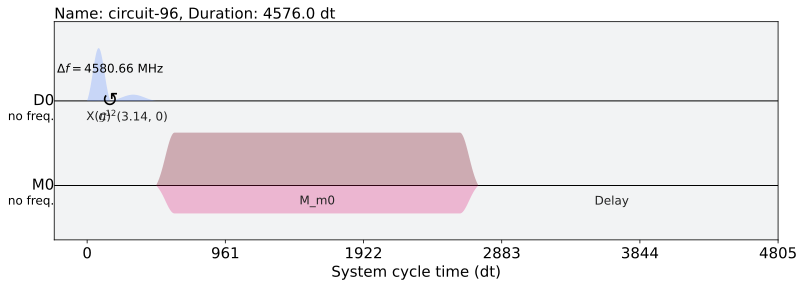

In [12]:
pi_01_x = Gate(r'$\pi_x^{(01)}$', 1, [])
pi_12_x = Gate(r'$\pi_x^{(12)}$', 1, [])
theta_12_x = Gate(r'$\theta_x^{(12)}$', 1, [])

gnd = QuantumCircuit(1, 1)
gnd.measure(0, 0)

fes = QuantumCircuit(1, 1)
#fes.append(pi_01_x, [0])
fes.x(0)
fes.measure(0, 0)
#fes.add_calibration(pi_01_x, (0,), g01(dur01, amp01, pi, beta01, 0), [])

ses = QuantumCircuit(1, 1)
#ses.append(pi_01_x, [0])
ses.x(0)
ses.append(pi_12_x, [0])
ses.measure(0, 0)
#ses.add_calibration(pi_01_x, (0,), g01(dur01, amp01, pi, beta01, 0), [])
ses.add_calibration(pi_12_x, (0,), g12(DUR12, AMP12_DEF, pi, BETA12, 0), [])

package = [gnd, fes, ses]

epsilon = 0.7*AMP12_DEF
amps = np.linspace(AMP12_DEF-epsilon, AMP12_DEF+epsilon, 97)

for amp in amps:
    amp12 = QuantumCircuit(1, 1)
    amp12.delay(0, 0, 'ns')
    #amp12.append(pi_01_x, [0])
    amp12.x(0)
    amp12.append(theta_12_x, [0])
    #amp12.add_calibration(pi_01_x, (0,), g01(dur01, amp01, pi, beta01, 0), [])
    amp12.add_calibration(theta_12_x, (0,), g12(DUR12, amp, pi, BETA12, 0), [])
    amp12.measure(0, 0)
    package.append(amp12) 
    
schedule(package[3], backend=backend).draw()

In [15]:
# amp12_job = backend.run(package, meas_level=1, meas_return='single', shots=2**14)
# print(amp12_job.job_id())
# job_monitor(amp12_job)

amp12_job = backend.retrieve_job('638df96e9a6b25f689b38bb0')
analyzer = DataAnalysis(experiment=amp12_job)
# gfs, IQ_data = analyzer.retrieveData(experiment=amp12_job, average=False)
# lda_012, score = analyzer.LDA(discrim_data=gfs, num_shots=2**14)
# raw_counted = analyzer.countPop(raw_data=IQ_data, LDA=lda_012, num_shots=2**14)
# assign_mat = raw_counted[0:3]
# mitiq_data = analyzer.errorMitiq(data=raw_counted, assign_matrix=assign_mat)
mitiq_data = analyzer.mitiq_data

Text(0, 0.5, '$P(|2\\rangle)$')

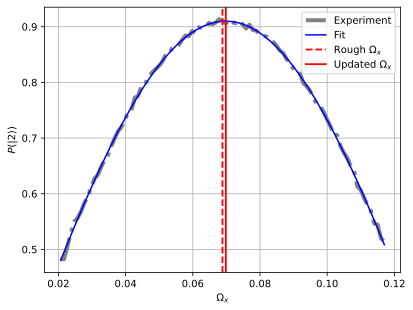

In [14]:
fit_params, y_fit = fit_function(amps,
                                 mitiq_data[3:, 2], 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 0, AMP12_DEF, 0])

amp12 = amps[np.argmax(y_fit)]

plt.figure()
plt.plot(amps, mitiq_data[3:, 2], linestyle='-.', color='gray', linewidth=4, label=r'Experiment')
plt.plot(amps, y_fit, color='blue', linewidth=1.5, label='Fit')
plt.axvline(AMP12_DEF, linestyle="--", color="r", linewidth=1.8, label=r'Rough $\Omega_x$')
plt.axvline(amp12, linestyle="-", color="red", linewidth=1.8, label=r'Updated $\Omega_x$')
plt.grid()
plt.legend()
plt.xlabel(r"$\Omega_x$")
plt.ylabel(r"$P(|2\rangle)$")

Text(0, 0.5, '$P(|2\\rangle)$')

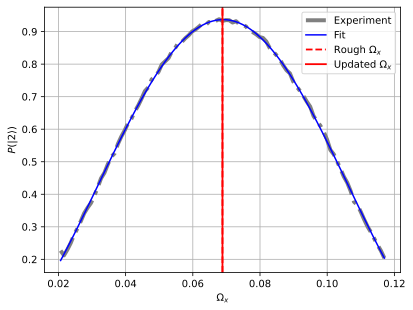

In [16]:
fit_params, y_fit = fit_function(amps,
                                 mitiq_data[3:, 2], 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 0, AMP12_DEF, 0])

amp12 = amps[np.argmax(y_fit)]

plt.figure()
plt.plot(amps, mitiq_data[3:, 2], linestyle='-.', color='gray', linewidth=4, label=r'Experiment')
plt.plot(amps, y_fit, color='blue', linewidth=1.5, label='Fit')
plt.axvline(AMP12_DEF, linestyle="--", color="r", linewidth=1.8, label=r'Rough $\Omega_x$')
plt.axvline(amp12, linestyle="-", color="red", linewidth=1.8, label=r'Updated $\Omega_x$')
plt.grid()
plt.legend()
plt.xlabel(r"$\Omega_x$")
plt.ylabel(r"$P(|2\rangle)$")

In [ ]:
# Result
amp12
with open('output.txt', 'w') as f:
    f.writelines(amp12)

: 

In [25]:
score = analyzer.score_012
score

0.97265625

amplitude = (0.17372619691492103+0j), beta = 0.2059415457247764, duration = 160, sigma = 40


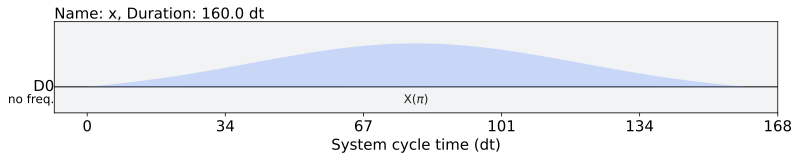

In [17]:
x_def = backend.defaults().instruction_schedule_map.get('x',qubits = [0])
x_def_pulse = x_def.instructions[0][1].pulse
print(f"amplitude = {x_def_pulse.amp}, beta = {x_def_pulse.beta}, duration = {x_def.duration}, sigma = {x_def_pulse.sigma}")
x_def.draw()


In [23]:
g01(160, AMP01, pi,  BETA01, 0)

ScheduleBlock(SetFrequency(4925058489.592224, DriveChannel(0)), ShiftPhase(0, DriveChannel(0)), Play(Drag(duration=160, amp=(0.1733298000991587+0j), sigma=40.0, beta=0.19019019019019012, name='$\mathcal{G}^{01}$(3.14, 0)'), DriveChannel(0), name='$\mathcal{G}^{01}$(3.14, 0)'), ShiftPhase(0, DriveChannel(0)), name="block105", transform=AlignLeft())

In [28]:
backend.defaults().qubit_freq_est[QUBIT]

4925058489.592224